### Transformer Translation - [notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl2/translation_transformer.ipynb)

**Todos**
* Use Bleu Metrics
* Remove run_train() from AppTransformer and inherit from AppBase. Pass in the InputTgtCB via the app_cbs argument.
* change db.do() to db.process()

**Done**
* DONE Move Text Translation Data Bundle and Bleu Metric into another common lib file and use it here and in Attention Bi-directional LSTM.ipynb. Note that this databundle as been modified by changing the len_key_fn lambda function. And added display params
*  DONE 

### Import KD Libraries

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import IPython.core.debugger as db
from pathlib import Path
from functools import partial
import math
#import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
gd_path = 'gdrive/My Drive/Colab Data/fastai-v3'  #change dir to your project folder
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

Mounted at /content/gdrive


In [5]:
from nb_util import save_pickle, load_pickle, accuracy, DebugRand
#from nb_data import DataBundle, CSVItemContainer, DfItemList, SentenceItemList, SentenceWordItemList, SentenceWordIdItemList, SortishSampler, SortSampler
#from nb_training import Trainer, Callback, CudaCB, ProgressCallback, MetricsGrp, LossMetricsCB, AverageMetricsCB, DebugTracker, DebugYhatLossCB
from nb_training import Trainer, Callback, CudaCB, ProgressCallback, AverageMetricsCB
from nb_optimiser import HyperParams, Recorder
from nb_arch import ArchBase
from nb_app import TextTranslationCSVDataBundle, AppBase

### Define Data File Paths

In [ ]:
# The Dataset is 'giga-fren', the same as used in the Text Translation app in the 
# 'Attention Bi-directional LSTM' notebook. That notebook contains the logic to download
# and pre-process the data and save it to a CSV file. Here, we treat that CSV file as
# our source data and load it directly.

app_dir='giga-fren'
root_path = Path.cwd()
g_data_path = Path(gd_path)/'data'
data_path = g_data_path/app_dir
data_file_path = data_path/'questions_easy.csv'

pickle_dir = root_path/'pickle'

### Build Transformer Architecture



![alt text](https://miro.medium.com/max/380/1*2vyKzFlzIHfSmOU_lnQE4A.png)

In [6]:
#----------------------------------------------------
# This callback is used to additionally pass the 'y' target values to the model 
# during training
#----------------------------------------------------
class InputTgtCB(Callback):
  # ----------------------------
  # During training, package the input data as a tuple (xb, yb) containing both the
  # 'x' and 'y' targets
  # ----------------------------
  def begin_tr_batch(self, ctx):
    ctx.xb = (ctx.xb, ctx.yb)

  # ----------------------------
  # !!!!!!! Do the same during validation
  # ----------------------------
  def begin_val_batch(self, ctx):
    ctx.xb = (ctx.xb, ctx.yb)

#----------------------------------------------------
# Transformer architecture. It consists of these modules:
#    1. Encoder - consists of a stack (usually 6) of sub-modules called Encoder Blocks
#    2. Decoder - consists of a stack (usually 6) of sub-modules called Decoder Blocks
#    3. Input Embedding - the input 'x' data is fed in to it. Consists of a regular 
#          Embedding layer and a Positional Encoding layer. 
#    4. Output Embedding - the target 'y' data is fed in to it. Consists of a regular 
#          Embedding layer and a Positional Encoding layer. Note that this data 
#          serves as an input to the Decoder. It is called 'Output' embedding because 
#          it processes the target data which the Transformer must learn to eventually
#          output. 
#    5. Generator - receives the output of the Decoder and generates the final output
#----------------------------------------------------
class Transformer(nn.Module):
  # ----------------------------
  # Create the main building blocks of the Transformer
  # 'n_blocks' - number of encoder and decoder blocks in the Encoder/Decoder
  # 'd_model' - number of embedding dimensions. This is carried throughout the architecture
  #       and most shapes use it.
  # 'n_heads' - number of multi-attention heads
  # ----------------------------
  def __init__(self, n_blocks, src_vocab_sz, tgt_vocab_sz, d_model=512, n_heads=8, 
               emb_drop_p=0.1, attn_drop_p=0.1, ff_drop_p=0.1, enc_drop_p=0.1, dec_drop_p=0.1):
    super().__init__()

    # 'Input Embedding' inputs to encoder. Embedding size is 'd_model'
    self.enc_emb = TransformerEmbedding(vocab_sz=src_vocab_sz, emb_sz=d_model, drop_p=emb_drop_p)
    # 'Output Embedding' inputs to decoder. Embedding size is 'd_model'
    self.dec_emb = TransformerEmbedding(vocab_sz=tgt_vocab_sz, emb_sz=d_model, drop_p=0.)

    # Set of Encoder Blocks and Decoder Blocks
    d_ff = 4 * d_model
    self.enc = nn.ModuleList([EncoderBlock(d_model=d_model, n_heads=n_heads, d_ff=d_ff, 
                                           attn_drop_p=attn_drop_p, ff_drop_p=ff_drop_p, enc_drop_p=enc_drop_p) 
                             for _ in range(n_blocks)])
    self.dec = nn.ModuleList([DecoderBlock(d_model=d_model, n_heads=n_heads, d_ff=d_ff, 
                                           attn_drop_p=attn_drop_p, ff_drop_p=ff_drop_p, dec_drop_p=dec_drop_p) 
                             for _ in range(n_blocks)])

    # Generator for output. Shares weights with the Output Embedding.
    dec_emb_wgts = self.dec_emb.get_emb_wgts()
    self.gen = Generator(in_sz=d_model, out_sz=tgt_vocab_sz, lin_wgts=dec_emb_wgts)

  # ----------------------------
  # Process the forward pass
  # ----------------------------
  def forward(self, inp):
    # The input text IDs 'x' has shape (samples, seq), aka (samples, timesteps) in 
    # RNN terminology. Similarly, 'y' has shape (samples, seq). Note that the sequence
    # length of the 'x' and 'y' data will be different as they are sentences in
    # different languages.
    if (isinstance(inp, tuple)):
      # 'yb' tgt is passed in only during training, by the Input Target callback
      xb, yb = inp
      yb = self.shift_tgt(yb)
    else:
      # 'yb' tgt is not passed during inference
      xb, yb = inp, None

    # Get embeddings from the input text IDs. 
    # The embeddings have shape (samples, seq, embedding size)
    enc_out = self.enc_emb(xb)
    # Generate a mask for the 'x' data, which is used for attention
    enc_mask = self.get_enc_mask(xb)
    # Go through all the encoder blocks sequentially. The output of one block is
    # passed as input to the next. Each output has shape (samples, seq, emb)
    for enc_blk in self.enc:
      enc_out = enc_blk(enc_out, enc_mask)

    if (yb is None):
      # We are in inference mode
      out_val = self._dec_inference (xb, enc_out, enc_mask)
    else:
      # We are in training mode
      out_val = self._decode (yb, enc_out, enc_mask)
    return out_val
  
    # Get embeddings from the output target text IDs
    # The embeddings have shape (samples, seq, embedding size)
    dec_out = self.dec_emb(yb)
    # Generate a mask for the 'y' data, which is used for attention
    dec_mask = self.get_dec_mask(yb)
    # Go through all the decoder blocks sequentially. The output of one block is
    # passed as input to the next. The encoder output is also passed to each decoder
    # block. Each decoder output has shape (samples, seq, emb)
    for dec_blk in self.dec:
      dec_out = dec_blk(dec_out, enc_out, enc_mask, dec_mask)

    # Generate the final output from the decoder output with shape (samples, tgt_vocab_sz, seq)
    out_val = self.gen(dec_out)
    return out_val

  # ----------------------------
  # Run one pass of the Decoder and generate output.
  # 
  # During training, only one pass per batch is required as all words in the sequence
  # are processed in parallel, using Teacher Forcing as the complete target output 
  # is available to us.
  # During inference this is called multiple times in a loop for each output word.
  # ----------------------------
  def _decode (self, yb, enc_out, enc_mask):
    # Get embeddings from the output target text IDs
    # The embeddings have shape (samples, seq, embedding size)
    dec_out = self.dec_emb(yb)
    # Generate a mask for the 'y' data, which is used for attention
    dec_mask = self.get_dec_mask(yb)
    # Go through all the decoder blocks sequentially. The output of one block is
    # passed as input to the next. The encoder output is also passed to each decoder
    # block. Each decoder output has shape (samples, seq, emb)
    for dec_blk in self.dec:
      dec_out = dec_blk(dec_out, enc_out, enc_mask, dec_mask)

    # Generate the final output from the decoder output with shape (samples, tgt_vocab_sz, seq)
    out_val = self.gen(dec_out)
    return out_val

  # ----------------------------
  # Run the Decoder in inference mode. During inference, the target output is not
  # available to us. So we run through the Decoder multiple times in a loop, generating
  # one additional output word each time. 
  #   Iteration 1 - Start by feeding in a single Start token, and generate the first output word. 
  #   Iteration 2 - Append that word to the Start token and feed it in,
  #          to generate the first and second output word.
  #   Iteration 3 - Repeat, and generate the first, second and third output word.
  #   Continue till an End token is encountered, or we reach the maximum number 
  #          of iterations.
  # ----------------------------
  def _dec_inference (self, xb, enc_out, enc_mask, pad_idx=1, tok_beg_idx=2):
    # Populate each sample in the batch with a Start token.
    yb = xb.new_full((xb.size(0), 1), tok_beg_idx)

    # Go through the loop till we we encounter the end of the output sentence, or we
    # reach the maximum number of iterations.
    i, max_loop = 0, 30
    end = False
    while ((i < max_loop) and (not end)):
      # Run the Decoder to generate the the next output word. 'Pred' contains has 
      # full output sequence thus far, and has shape (samples, seq)
      out_val = self._decode(yb, enc_out, enc_mask)
      pred = out_val.argmax(dim=1)

      if (pred[:, -1] == pad_idx).all():
        # End the loop if we just predicted a padding token, which means we've
        # reached the end of the sequence
        end = True

      else:
        # Pass in the complete output sequence thus far (including the last 
        # outputted word), after prepending the Start token to the sequence.
        yb = F.pad(pred, (1, 0), value=tok_beg_idx)

        # Go to the next timestep
        i += 1

    return out_val

  # ----------------------------
  # Shift the output target right by one position, and add one padding token 
  # in the first position
  # ----------------------------
  def shift_tgt(self, y, pad_idx=1):
    y = F.pad(y, (1, 0), value=pad_idx)
    y = y[:,:-1]
    return y

  # ----------------------------
  # Mask used for the input 'x' data. It is used in the attention layer to mask
  # out the padding tokens at the end of each sentence.
  # Mask has shape (samples, 1, 1, seq). Refer to Attention module
  # for details.
  # ----------------------------
  def get_enc_mask(self, x, pad_idx=1):
    # 'x_mask' has shape (samples, seq)
    x_mask = (x == pad_idx)
    # Reshape as required for attention to (samples, 1, 1, seq)
    x_mask = x_mask.unsqueeze(1).unsqueeze(2)
    return x_mask

  # ----------------------------
  # Mask used for the target 'y' data. The output for the i'th word should refer only
  # to the 0 to i-1'th words, and should not peek into later words. This mask is used 
  # in the attention layer to mask out the subsequent i+1'th and later words.
  # Mask has shape (1, 1, seq, seq). Refer to Attention module
  # for details.
  # ----------------------------
  def get_dec_mask(self, y):
    # 'y_true' and 'y_mask' have shape (seq, seq)
    y_true = y.new_ones((y.size(1), y.size(1)), dtype=torch.bool)
    y_mask = torch.triu(y_true, diagonal=1)
    # Reshape as required by attention to (1, 1, seq, seq)
    y_mask = y_mask.unsqueeze(0).unsqueeze(1)
    return y_mask

#----------------------------------------------------
# TransformerEmbedding Module, used to pass embedded data to the Encoder and
# the Decoder
#----------------------------------------------------
class TransformerEmbedding(nn.Module):
  # ----------------------------
  # Create a regular Embedding layer and a Position Encoding layer
  # ----------------------------
  def __init__(self, vocab_sz, emb_sz, drop_p):
    super().__init__()

    # Embedding layer
    self.emb_sz = emb_sz
    self.emb = nn.Embedding(vocab_sz, emb_sz)

    # Position Encoding layer
    self.pos_emb = PositionEncoding(emb_sz)

    # Embedding dropout
    self.drop = nn.Dropout(drop_p)

  # ----------------------------
  # Process the forward pass
  # ----------------------------
  def forward(self, inp):
    # Get regular embeddings and scale the values
    # Shape (samples, seq, embedding size)
    scaled_emb = self.emb(inp) * math.sqrt(self.emb_sz)

    # Encode the relative position of each word in the sequence
    # Shape (samples, seq, embedding size)
    pos = torch.arange(0, inp.size(1), device=inp.device).float()
    pos_encoding = self.pos_emb(pos)

    # Combine the embedding with the position encoding
    emb_out = scaled_emb + pos_encoding

    # Embedding dropout
    emb_out = self.drop(emb_out)
    return emb_out

  # ----------------------------
  # Return embedding weights
  # ----------------------------
  def get_emb_wgts(self):
    return self.emb.weight

#----------------------------------------------------
# PositionEncoding Module
#----------------------------------------------------
class PositionEncoding(nn.Module):
  # ----------------------------
  # Pre-calculate constant coefficients for every even index in the embedding dimension
  # ----------------------------
  def __init__(self, emb_sz):
    super().__init__()
    self.emb_sz = emb_sz
    self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., emb_sz, 2.)/emb_sz)))

  # ----------------------------
  # Compute the encoding for every (position, emb_idx) combination where:
  #   position  - position of a word in the sequence
  #   emb_idx   - index of the i'th value in the embedding
  # ----------------------------
  def forward(self, pos):
    # 'pos' is a vector [0, 1, ... seq_len] of every position in the sequence

    # ger() returns a 2D matrix with every combination of the (position, emb_idx) pair:
    #    rows correspond to every position from [0, 1, ... seq_len]
    #    columns correspond to every second embedding index from [0, 2, 4, ... embedding size]
    inp = torch.ger(pos, self.freq)

    # For every sequence position, calculate:
    #    sin curve for even indexes from [0, ... emb sz]. There are emb_sz/2 values.
    #    cos curve for even indexes from [0, ... emb sz]. There are emb_sz/2 values.
    # Then populate the position encoding by interleaving the sin and cos curves
    # such that:
    #    the sin curve values fill the even positions in the encoding
    #    the cos curve values fill the odd positions in the encoding
    # Hence the position encoding now has a shape of (seq, emb_sz)
    seq_len = pos.size(0)
    pos_encoding = torch.zeros(seq_len, self.emb_sz, device=pos.device)
    pos_encoding[:, 0::2] = inp.sin()
    pos_encoding[:, 1::2] = inp.cos()
    return pos_encoding

#----------------------------------------------------
# EncoderBlock Module. These get stacked up to form an Encoder. Each block consists
# of two sub-layers. Each sub-layer contains a Residual Skip-connection that does 
# Add & Norm:
#   1a - Multi-head Attention with 
#   1b -    Skip-connection (around the Attention layer) 
#   2a - Fully-connected Feed Forward
#   2b -    Skip-connection (around the Feed Forward layer)
#----------------------------------------------------
class EncoderBlock(nn.Module):
  # ----------------------------
  # Create the sub-layers for an Encoder Block
  # ----------------------------
  def __init__(self, d_model, n_heads, d_ff, attn_drop_p, ff_drop_p, enc_drop_p):
    super().__init__()
    # Sublayer 1 - Multi-head Self-Attention and Residual Add & Norm
    self.mha_self = MultiHeadAttention(d_model, n_heads, attn_drop_p)
    self.an1 = AddNorm(d_model, enc_drop_p)

    # Sublayer 2 - Feed-Forward and Residual Add & Norm
    self.ff = FeedForward(d_model=d_model, d_ff=d_ff, drop_p=ff_drop_p)
    self.an2 = AddNorm(d_model, enc_drop_p)

  # ----------------------------
  # Process the forward pass
  # We are given 'x', the output from the previous Encoder Block. For the first
  # Encoder Block in the stack, 'x' is the output of the Transformer's Input Embedding
  # layer. 
  # ----------------------------
  def forward(self, x, mask):
    # Sublayer 1 - Multi-head Self-attention, followed by Residual Add & Norm
    # 'x', 'attended' and 'outp' have shape (samples, seq, emb)
    attended = self.mha_self(x, x, x, mask)
    outp = self.an1(x, attended)

    # Sublayer 2 - Feed-forward, followed by Residual Add & Norm
    # Takes the output of sub layer 1
    # 'fedforward' and 'outp' have shape (samples, seq, emb)
    fedforward = self.ff(outp)
    outp = self.an2(outp, fedforward)

    return outp

#----------------------------------------------------
# MultiHeadAttention Module. This is the heart of the Transformer architecture and
# where most of the complexity is. It consists of 3 linear layers for the Query,
# Key and Value and a final linear layer for the output of the module.
#
# The structure and computations are the same for both Self-Attention and 
# Encoder attention. The only difference is in the input values passed in for
# the query, key and value arrays.
#   For Encoder Self-Attention we pass in (x, x, x, x_enc_mask)
#   For Decoder Self-Attention we pass in (y, y, y, y_dec_mask)
#   For Decoder's Encoder Attention we pass in (dec self-attn output, enc output, enc output, x_enc_mask)
#----------------------------------------------------
class MultiHeadAttention(nn.Module):
  # ----------------------------
  # Create the modules of the Attention block
  # ----------------------------
  def __init__(self, d_model, n_heads, attn_drop_p):
    super().__init__()
    # Number of attention heads
    self.n_heads = n_heads
    # Dimensions of the Query, Key and Value vectors
    self.d_head = d_head = d_model // n_heads

    # Query, Key and Value
    self.q_wgt = nn.Linear(d_model, d_head * n_heads)
    self.k_wgt = nn.Linear(d_model, d_head * n_heads)
    self.v_wgt = nn.Linear(d_model, d_head * n_heads)

    # Output
    self.out = nn.Linear(d_head * n_heads, d_model)

    # Dropout
    self.drop_att = nn.Dropout(attn_drop_p)

  # ----------------------------
  # Self Attention
  # ----------------------------
  def forward(self, query, key, value, mask):
    # query, key and value have the same shape (samples, seq, emb)
    num_samples, query_seq_len, _ = query.size()

    # Compute Q = W_q * q, split across the 'n_heads' heads
    # Shapes are: 
    #   W_q * q = (samples, seq, emb)
    #   view() splits it across heads = (samples, seq, heads, d_head), where emb = heads * d_head
    #   permute() rearranges the axes = (samples, heads, seq, d_head)
    #   Hence, W has shape (samples, heads, seq, d_head)
    q = self.q_wgt(query).view(num_samples, query.size(1), self.n_heads, self.d_head)
    q = q.permute(0, 2, 1, 3)

    # Similar steps to compute K_transpose = W_k * k, split across the 'n_heads' head
    # K_transpose has shape (samples, heads, d_head, seq) ie. the last two columns
    # have been transposed.
    k = self.k_wgt(key).view(num_samples, key.size(1), self.n_heads, self.d_head)
    k = k.permute(0, 2, 3, 1)

    # Similar steps to compute V = W_v * v, , split across the 'n_heads' head
    # V has shape (samples, heads, seq, d_head)
    v = self.v_wgt(value).view(num_samples, value.size(1), self.n_heads, self.d_head)
    v = v.permute(0, 2, 1, 3)

    # Compute (Q * K_transpose) / sqrt(d_head)
    # Shape is (samples, heads, seq, seq)
    # With 4D arrays, matrix multiplication preserves the first two dimensions and
    # multiples the last two dimensions. So the shapes are:
    # (samples, heads, seq, d_head) * (samples, heads, d_head, seq) = (samples, heads, seq, seq)
    logits = torch.matmul(q, k)
    logits = logits.div_(self.d_head ** 0.5)
    
    # Apply the mask by setting the mask's 'False' values to negative infinity. That
    # way the softmax() converts all those values to '0'.
    # Mask has shape (samples, 1, 1, seq ) or (1, 1, seq, seq), so it can be
    # broadcast to the logits which has shape (samples, heads, seq, seq)
    logits = logits.float().masked_fill(mask, -float('inf')).type_as(logits)
    attn_prob = F.softmax(logits, dim=-1)
    attn_prob = self.drop_att(attn_prob)

    # Above, we computed 'attn_prob' = Softmax((Q * K_transpose) / sqrt(d_head))
    # The last step of the attention formula is: Attn = attn_prob * V
    # It has shape (samples, heads, seq, d_head)
    attn_vec = torch.matmul(attn_prob, v)
    # Merge the 'n_heads', which we had split earlier, into a single result
    # Shapes are:
    #   permute() rearranges the axes = (samples, seq, heads, d_head)
    #   view() merges the heads = (samples, seq, heads * d_head) = (samples, seq, emb)
    attn_vec = attn_vec.permute(0, 2, 1, 3).contiguous()
    attn_vec = attn_vec.view(num_samples, query_seq_len, -1)

    # Final linear layer. Shape doesn't change = (samples, seq, emb)
    outp = self.out(attn_vec)

    return outp

#----------------------------------------------------
# FeedForward Module. This is part of each Encoder and Decoder Blocks. It has
# two Linear layers with ReLU and Dropout.
#----------------------------------------------------
class FeedForward(nn.Module):
  # ----------------------------
  # 
  # ----------------------------
  def __init__(self, d_model, d_ff, drop_p):
    super().__init__()
    self.lin1 = nn.Linear(d_model, d_ff)
    self.relu = nn.ReLU()
    self.lin2 = nn.Linear(d_ff, d_model)
    self.drop = nn.Dropout(drop_p)

  # ----------------------------
  # Process the forward pass
  # ----------------------------
  def forward(self, x):
    outp = self.lin2(self.drop(self.relu(self.lin1(x))))
    return outp

#----------------------------------------------------
# AddNorm Module. This is part of each Encoder and Decoder Blocks. It 
# implements the Residual Skip-Connection with LayerNorm
#----------------------------------------------------
class AddNorm(nn.Module):
  # ----------------------------
  # Create the LayerNorm and Dropout Layers
  # ----------------------------
  def __init__(self, d_model, drop_p):
    super().__init__()
    self.norm = nn.LayerNorm(d_model)
    self.drop = nn.Dropout(drop_p)

  # ----------------------------
  # A residual skip-connection adds the original input to the processed output
  # of the sub layer. Then pass that through a LayerNorm and Dropout
  # ----------------------------
  def forward(self, x, x_out):
    outp = self.norm(x + x_out)
    outp = self.drop(outp)

    return outp

#----------------------------------------------------
# DecoderBlock Module. These get stacked up to form an Decoder. Each block consists
# of three sub-layers. Each sub-layer contains a Residual Skip-connection that does 
# Add & Norm:
#   1a - Multi-head Attention for processing Decoder data input (see below), with
#   1b -    Skip-connection (around the Attention layer) 
#   1a - Multi-head Attention for processing data output by the Encoder, with
#   1b -    Skip-connection (around the Attention layer) 
#   3a - Fully-connected Feed Forward
#   3b -    Skip-connection (around the Feed Forward layer)
#
# For the first Decoder Block in the stack, the data input for sub-layer 1a comes 
# from the Transformer's Output Embedding layer. For subsequent Decoder Blocks, 
# the data input comes from the output of the previous Decoder Block.
#----------------------------------------------------
class DecoderBlock(nn.Module):
  # ----------------------------
  # Create the sub-layers for a Decoder Block
  # ----------------------------
  def __init__(self, d_model, n_heads, d_ff, attn_drop_p, ff_drop_p, dec_drop_p):
    super().__init__()
    # Sublayer 1 - Multi-head Self-Attention and Residual Add & Norm
    self.mha_self = MultiHeadAttention(d_model, n_heads, attn_drop_p)
    self.an1 = AddNorm(d_model, dec_drop_p)

    # Sublayer 2 - Multi-head Encoder-Attention and Residual Add & Norm
    self.mha_enc = MultiHeadAttention(d_model, n_heads, attn_drop_p)
    self.an2 = AddNorm(d_model, dec_drop_p)

    # Sublayer 3 - Feed-Forward and Residual Add & Norm
    self.ff = FeedForward(d_model=d_model, d_ff=d_ff, drop_p=ff_drop_p)
    self.an3 = AddNorm(d_model, dec_drop_p)

  # ----------------------------
  # Process the forward pass
  # We are given the Encoder output, as well as 'y', which is the output from 
  # the previous Decoder Block. For the first Decoder Block in the stack, 'y' 
  # is the output from the Transformer's Output Embedding layer.
  # ----------------------------
  def forward(self, y, enc_out, enc_mask, dec_mask):
    # Sublayer 1 - Multi-head self-attention (for Decoder input), followed 
    # by Residual Add & Norm
    # 'y', 'attended' and 'outp' have shape (samples, seq, emb)
    attended = self.mha_self(y, y, y, dec_mask)
    outp = self.an1(y, attended)

    # Sublayer 2 - Multi-head Encoder-Attention (for Encoder's encoded output), followed 
    # by Residual Add & Norm
    # 'attended_enc' and 'outp' have shape (samples, seq, emb)
    # Pass output from sub layer 1 as the query parameter and the output from the
    # Encoder as the key and value parameters to the Attention module.
    attended_enc = self.mha_enc(outp, enc_out, enc_out, enc_mask)
    outp = self.an2(outp, attended_enc)

    # Sublayer 3 - Feed-Forward, followed by Residual Add & Norm
    # 'fedforward' and 'outp' have shape (samples, seq, emb)
    fedforward = self.ff(outp)
    outp = self.an3(outp, fedforward)

    return outp

#----------------------------------------------------
# Generator Module. Receives the output from the Decoder and generates the final
# output of the Transformer. 
#----------------------------------------------------
class Generator(nn.Module):
  # ----------------------------
  # Create the Linear layer. It shares weights with the Output Embedding Layer, which
  # are passed in here.
  # ----------------------------
  def __init__(self, in_sz, out_sz, lin_wgts):
    super().__init__()
    self.lin = nn.Linear(in_sz, out_sz)
    # Use the same weights as the Embedding Layer.
    self.lin.weight = lin_wgts

  # ----------------------------
  # Process the forward pass. We don't do a Softmax here as it is done within
  # the Cross Entropy Loss function.
  # ----------------------------
  def forward(self, outp):
    outp = self.lin(outp)
    # Change shape from (samples, seq, num_classes) to (samples, num_classes, seq) as
    # required for cross entropy loss
    outp = outp.permute(0, 2, 1)
    return outp

#----------------------------------------------------
# Create the Transformer Encoder-Decoder architecture
#----------------------------------------------------
class ArchTransformerTranslation(ArchBase):
  # ----------------------------
  # Create the Transformer model
  # ----------------------------
  def create_model(self, src_vocab_sz, tgt_vocab_sz):
    self.model = Transformer(1, src_vocab_sz, tgt_vocab_sz) 

  def module_groups(self):
    pass

  def hook_groups(self):
    pass

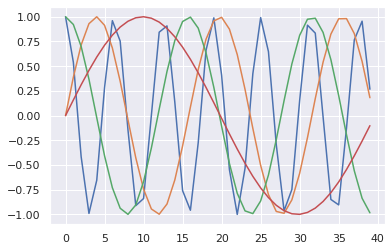

In [16]:
# In this example, we encode 40 positions and an Encoding size of 20
# We then plot the value of the first four encoding 'columns'
# eg. Blue plot - shows the value of the first encoding column for all 40 positions
# eg. Orange plot - shows the value of the second encoding column for all positions
# eg. Green plot - shows the value of the third encoding column for all positions
# eg. Red plot - shows the value of the fourth encoding column for all positions
# and so on for all the 20 encoding columns, but that would get too busy, so we limit to 4.
import matplotlib.pyplot as plt
tst_encoding = PositionEncoding(20)
res = tst_encoding(torch.arange(0,40).float())
_, ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i])

### Define Transformer Translation application class 

In [ ]:
#----------------------------------------------------
# Transformer Translation Application. It translates text sentences from an 'x' language into
# a 'y' language, using a Transformer Encoder-Decoder architecture.
#
# Here, we translate from French to English
#
# To use it, the steps are:
#   1. Load the (pre-processed) data from a CSV file
#   2. Create the architecture and train it
#   3. Run predictions
#----------------------------------------------------
class AppTransformerTranslation(AppBase):

  def __init__(self):
    super().__init__(loss_type='multi_classif', metrics_cbs=[AverageMetricsCB(accuracy)])
    self.vocab_x = None
    self.vocab_y = None

    self.debug_cbs = []
    self.dtr = None
    self.hooks = None
 
  #----------------------------------------------------
  # Load the data using the Text Translation Data Bundle
  #----------------------------------------------------
  def load_data(self, file_path, bs):
    self.db = TextTranslationCSVDataBundle(file_path, bs)
    self.db.process()
    self.vocab_x = self.db.convert_state_x['vocab_i2w']
    self.vocab_y = self.db.convert_state_y['vocab_i2w']

  #----------------------------------------------------
  # Create the architecture
  #----------------------------------------------------
  def create_arch(self):
    self._arch = ArchTransformerTranslation()
    self._arch.create_model(len(self.vocab_x), len(self.vocab_y))
    return self._arch

  #----------------------------------------------------
  # Train the model
  #----------------------------------------------------
  def run_train(self, num_epochs=1, split_lr=[1e-3], weight_decay=0.2, one_cycle=False):
    assert(isinstance(one_cycle, bool))

    train_dl = self.db.train_dl
    valid_dl = self.db.valid_dl

    # Loss function
    loss_func = self.loss_fn

    # Model
    arch = self._arch
    model = arch.model

    opt_adamw = partial(optim.AdamW, betas=(0.9, 0.99), weight_decay=weight_decay)
    lr_sched='one_cycle' if one_cycle else None
    opt, hyper_cbs = HyperParams.set(model, module_groups=None, split_lr=split_lr, split=False, lr_sched=lr_sched, opt_func=opt_adamw)

    gpu_cbs = [CudaCB(device = torch.device('cuda',0))]
    track_cbs = [Recorder(), ProgressCallback()]
    callbs = gpu_cbs + track_cbs
    callbs += [InputTgtCB()]
    callbs += self.metrics_cbs + hyper_cbs + self.debug_cbs

    loop = Trainer(train_dl, valid_dl, model, opt, loss_func, callbs, dtr=self.dtr)
    loop.hooks = self.hooks

    loop.fit(num_epochs=num_epochs)
    return loop

  #----------------------------------------------------
  # Train the model
  #----------------------------------------------------
  def run_predict(self):
    valid_dl = self.db.valid_dl
    self._arch.model.eval()
    device = list(self._arch.model.parameters())[0].device

    inps, outs, targs = [], [], []
    with torch.no_grad():
      for _, (xb, yb) in enumerate(valid_dl):
        xb = xb.to(device)
        yhat = self._arch.model(xb)
        pred = yhat.argmax(dim=1)
        for x, y, p in zip (xb, yb, pred):
          inp = [w for w in x]
          inps.append(inp)
          out = [w for w in p]
          outs.append(out)
          targ = [w for w in y]
          targs.append(targ)
    return inps, outs, targs

### Load data and run model

In [ ]:
# OPTIONAL - create small data subset for quick iteration

import pandas as pd
easy_df = pd.read_csv(data_file_path)
easy_df = easy_df.iloc[:640, :]
data_file_path=pickle_dir/'easy.csv'
pickle_dir.mkdir(exist_ok=True)
easy_df.to_csv(data_file_path)
easy_df

In [ ]:
trt_app = AppTransformerTranslation()
trt_app.load_data(data_file_path, bs=64)
save_pickle(trt_app, pickle_dir, 'proc_data.pkl')

In [ ]:
trt_app.db.display_batch()

In [ ]:
DebugRand.set_seed(0)
trt_app = load_pickle(pickle_dir/'proc_data.pkl')

trt_app.create_arch()
trt_app._arch.save_weights(pickle_dir/'arch_init_wgts.mdl')
trt_app._arch.load_weights(pickle_dir/'arch_init_wgts.mdl')

trt_app.create_debug(use_dtr=True, track_batches_per_epoch=10, disp_tb=False, disp_pd=True, debug_bkwd=False, debug_fwd=False, abort_iter=0)

In [ ]:
find_lr = True
if (find_lr):
  loop = trt_app.lr_find(start_lr=1e-7, end_lr=10, num_iter=100, app_cbs=[InputTgtCB()])

In [ ]:
loop = trt_app.run_train(num_epochs=2, split_lr=[9e-5])

In [ ]:
# Be careful about running this. Do it only when we get results that are better
# than the already saved model
#torch.save(trt_app._arch.model.state_dict(), data_path/'arch_init_wgts.mdl')

(None, None)

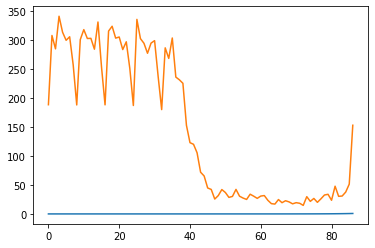

In [ ]:
recorder=loop.cbs[1]
recorder.plot_lr(), recorder.plot_loss()

In [ ]:
is_run_df, is_batch_df, is_layer_df, _ = loop.dtr.pd_results()
is_run_df
is_batch_df.head(2)
is_layer_df.head(2)

In [ ]:
display_metrics(is_batch_df)

In [ ]:
!rm -r tbtry

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir tbtry

In [ ]:
## Save last good run
## Compare with last good run

In [ ]:
inps, outs, targs = trt_app.run_predict()
#inps[4], outs[4], targs[4]
# !!!!! To use display_results, run_predict() should return raw word_ids, not strings
trt_app.db.display_results(inps, targs, outs)

### Results

In [ ]:
# KD - this was done after 50-100 epochs initial training

epoch	tr_loss	smooth_loss	val_loss	accuracy	time
0	1.297374	1.264186	1.532392	0.749846	00:46
1	1.283057	1.369950	1.518940	0.751533	00:45
2	1.267440	1.267844	1.518252	0.750729	00:46
3	1.262145	1.213428	1.536164	0.751367	00:46
4	1.238970	1.307094	1.515154	0.752071	00:46
5	1.225672	1.247624	1.516172	0.751638	00:46
....
40	0.864952	0.859828	1.482309	0.765684	00:46
41	0.861147	0.912387	1.478079	0.766861	00:46
42	0.848906	0.878155	1.480625	0.765558	00:46
43	0.834448	0.913112	1.484522	0.766523	00:46
44	0.829470	0.831285	1.483043	0.767392	00:46
45	0.821001	0.787937	1.491541	0.767248	00:46
46	0.811043	0.775267	1.489604	0.767324	00:46
47	0.800593	0.793480	1.485361	0.767945	00:46
48	0.797962	0.795403	1.486552	0.767482	00:46
49	0.789575	0.815243	1.491208	0.768151	00:46